In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import scipy

## load data

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)

In [4]:
pth_data = '../data/train.csv'
df_origin = pd.read_csv(pth_data)

In [5]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,2020-10-19 14:00:00,1.64,54.0,1,20.077335,24,77.990,62.122,NaN,17.0,NaN,NaN,4.0,4.0,0.74,1.0
1,2020-10-19 14:30:00,1.64,54.0,1,20.077335,24,78.208,62.321,NaN,60.0,30.748,0.926320,4.0,4.0,0.74,1.1
2,2020-10-19 15:00:00,1.64,54.0,1,20.077335,24,78.514,62.255,NaN,46.0,31.327,1.232405,4.0,4.0,0.74,1.1
3,2020-10-19 15:30:00,1.64,54.0,1,20.077335,24,79.041,61.491,NaN,91.0,31.458,0.375005,4.0,4.0,0.74,1.0
4,2020-10-19 16:00:00,1.64,54.0,1,20.077335,24,79.435,61.071,NaN,71.0,32.085,0.081127,4.0,4.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,76.528,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,76.876,39.890,NaN,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,77.050,39.710,NaN,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,76.703,39.980,NaN,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


In [6]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2796 non-null   object 
 1   height        2796 non-null   float64
 2   weight        2796 non-null   float64
 3   gender        2796 non-null   int64  
 4   bmi           2796 non-null   float64
 5   age           2796 non-null   int64  
 6   env_temp      2796 non-null   float64
 7   rh            2796 non-null   float64
 8   heart_rate    1669 non-null   float64
 9   stress_level  1848 non-null   float64
 10  skin_temp     1874 non-null   float64
 11  eda           2396 non-null   float64
 12  TC            2717 non-null   float64
 13  TS            2712 non-null   float64
 14  Clo           2737 non-null   float64
 15  Act           2718 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 349.6+ KB


## data process

### choose data: TS >= 4.0

In [7]:
df_origin[df_origin[['TS']].isna().TS].shape
# some na in clo, means unrecorded data

(84, 16)

In [8]:
df_record = df_origin[df_origin['TS'].isna() ^ True]

In [9]:
df_record.shape

(2712, 16)

In [10]:
df_comfort = df_record[df_record['TC'] >= 4.0]

### visualization

In [11]:
df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'TC', 'TS', 'Clo', 'Act', 'env_temp']]
# df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age']]

In [12]:
df_visual.head()

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act,env_temp
0,1.64,54.0,1,20.077335,24,62.122,NaN,17.0,NaN,NaN,4.0,4.0,0.74,1.0,77.990
1,1.64,54.0,1,20.077335,24,62.321,NaN,60.0,30.748,0.926320,4.0,4.0,0.74,1.1,78.208
2,1.64,54.0,1,20.077335,24,62.255,NaN,46.0,31.327,1.232405,4.0,4.0,0.74,1.1,78.514
3,1.64,54.0,1,20.077335,24,61.491,NaN,91.0,31.458,0.375005,4.0,4.0,0.74,1.0,79.041
4,1.64,54.0,1,20.077335,24,61.071,NaN,71.0,32.085,0.081127,4.0,4.0,0.74,1.0,79.435


#### pairplot
download it to zoom in

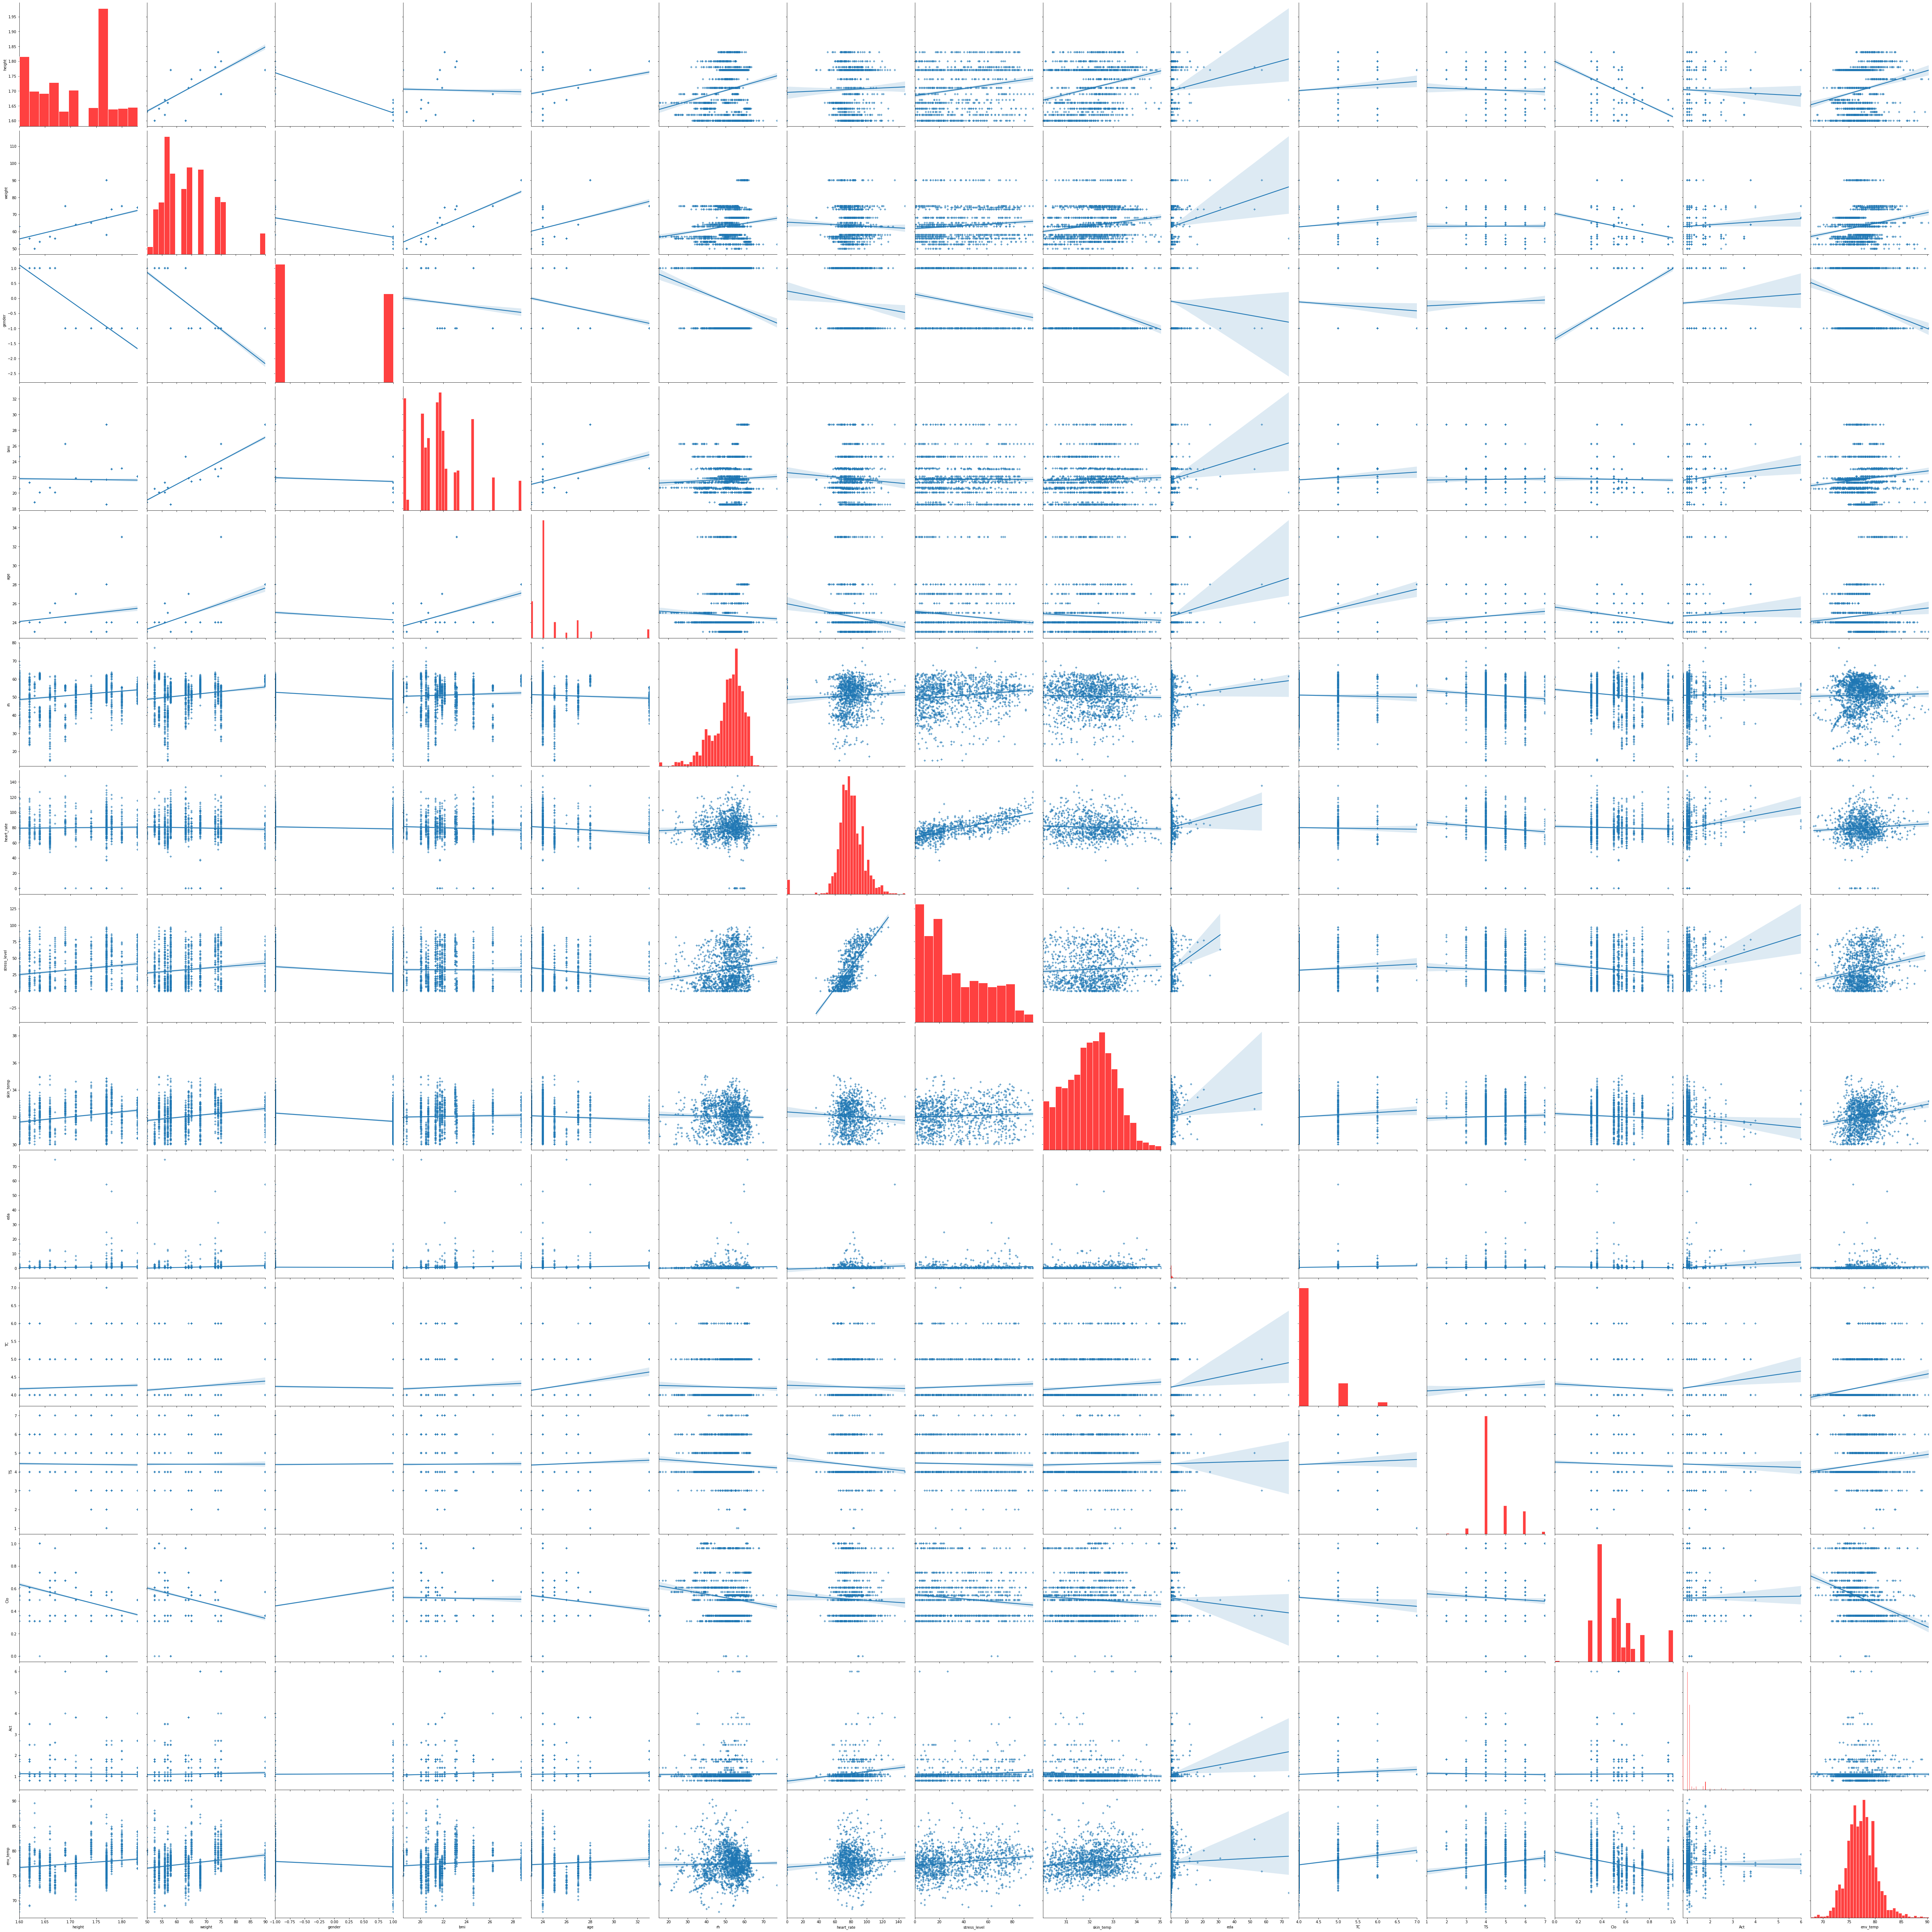

In [13]:
sns.pairplot(df_visual, dropna=True, kind='reg', markers='+', height=5, aspect=1,
            diag_kws=dict(edgecolor="w", color="r"))

#### correlation map

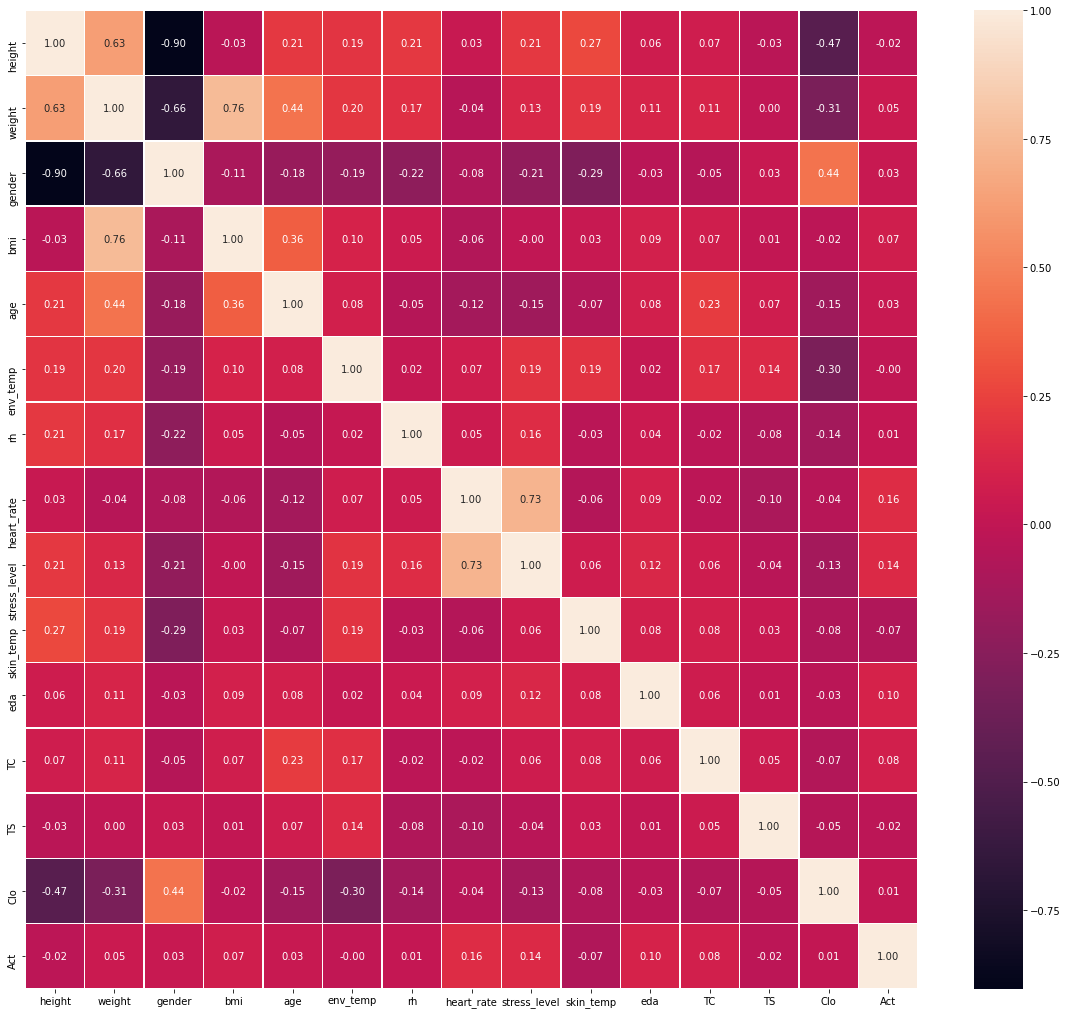

In [14]:
# correlation map
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(df_comfort.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### shuffle

In [15]:
df_shuffle = df_comfort.sample(frac=1, random_state=1208).reset_index(drop=True)

In [16]:
X_data = df_shuffle[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'TC', 'TS', 'Clo', 'Act']]

In [17]:
X_cols_name = X_data.columns

In [18]:
y_data = df_shuffle['env_temp']

### imputation

In [19]:
df_record[df_record[['env_temp']].isna().env_temp]
# no na in env_temp

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act


In [20]:
imp = SimpleImputer(strategy='mean')

In [21]:
X_data = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

In [22]:
X_data

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,1.60,52.5,1.0,20.507812,24.0,40.172,89.000000,45.000000,32.058593,0.149122,4.0,4.0,0.36,1.1
1,1.62,56.0,1.0,21.338211,24.0,32.468,79.838667,45.000000,31.196000,0.033003,5.0,6.0,0.61,1.1
2,1.77,68.0,-1.0,21.705129,24.0,56.173,91.000000,78.000000,30.061000,0.011916,4.0,4.0,0.54,1.1
3,1.77,58.0,-1.0,18.513199,23.0,48.688,73.000000,0.000000,32.058593,0.007841,4.0,4.0,0.36,2.5
4,1.60,52.5,1.0,20.507812,24.0,59.597,95.000000,76.000000,32.058593,1.724577,5.0,4.0,0.53,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,1.60,63.0,1.0,24.609375,24.0,55.950,92.000000,32.636834,32.059000,0.039074,4.0,4.0,0.50,1.1
1828,1.62,56.0,1.0,21.338211,24.0,61.138,79.838667,63.000000,32.058593,0.082877,5.0,5.0,0.57,3.5
1829,1.69,75.0,-1.0,26.259585,24.0,38.920,101.000000,32.636834,31.745000,0.003170,4.0,5.0,0.67,1.0
1830,1.60,52.5,1.0,20.507812,24.0,46.515,79.838667,32.636834,32.058593,-0.087225,4.0,4.0,0.61,1.1


### normalize

In [23]:
X_array_normalize, X_norm = normalize(X_data, axis=0, return_norm=True)

In [24]:
X_data = pd.DataFrame(X_array_normalize, columns=X_cols_name)

In [25]:
X_data

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,0.021923,0.019233,0.023363,0.021921,0.022599,0.018144,0.025695,0.026999,0.023355,0.001129,0.022014,0.020820,0.015321,0.021447
1,0.022197,0.020515,0.023363,0.022809,0.022599,0.014664,0.023050,0.026999,0.022727,0.000250,0.027517,0.031230,0.025961,0.021447
2,0.024252,0.024912,-0.023363,0.023201,0.022599,0.025371,0.026273,0.046798,0.021900,0.000090,0.022014,0.020820,0.022982,0.021447
3,0.024252,0.021248,-0.023363,0.019789,0.021658,0.021990,0.021076,0.000000,0.023355,0.000059,0.022014,0.020820,0.015321,0.048743
4,0.021923,0.019233,0.023363,0.021921,0.022599,0.026917,0.027428,0.045598,0.023355,0.013060,0.027517,0.020820,0.022556,0.023397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,0.021923,0.023080,0.023363,0.026306,0.022599,0.025270,0.026561,0.019581,0.023355,0.000296,0.022014,0.020820,0.021280,0.021447
1828,0.022197,0.020515,0.023363,0.022809,0.022599,0.027613,0.023050,0.037798,0.023355,0.000628,0.027517,0.026025,0.024259,0.068241
1829,0.023156,0.027476,-0.023363,0.028069,0.022599,0.017578,0.029160,0.019581,0.023127,0.000024,0.022014,0.026025,0.028515,0.019497
1830,0.021923,0.019233,0.023363,0.021921,0.022599,0.021009,0.023050,0.019581,0.023355,-0.000661,0.022014,0.020820,0.025961,0.021447


In [26]:
X_norm

array([  72.98249448, 2729.66128851,   42.80186912,  935.52161717,
       1061.9802258 , 2214.07036967, 3463.67537818, 1666.74155966,
       1372.66259513,  132.05507768,  181.70580618,  192.12495934,
         23.49662316,   51.28918015])

### split: train & test

In [27]:
def split_into_train_test(X, y, frac=0.8):
    n_rows = y.shape[0]
    n_rows_train = int(n_rows * frac)
    # n_rows_test = n_rows - n_rows_train

    X_train = X[:n_rows_train]
    y_train = y[:n_rows_train]

    X_test = X[n_rows_train:]
    y_test = y[n_rows_train:]
    return X_train, y_train, X_test, y_test

In [28]:
n_rows = y_data.shape[0]

In [29]:
train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

In [30]:
X_train = X_data[:n_rows_train]
y_train = y_data[:n_rows_train]

In [31]:
X_test = X_data[n_rows_train:]
y_test = y_data[n_rows_train:]

## linear regression (1st try)

### single linear regression
env_temp = f(each feature individually)

In [32]:
n_features = X_train.shape[1]

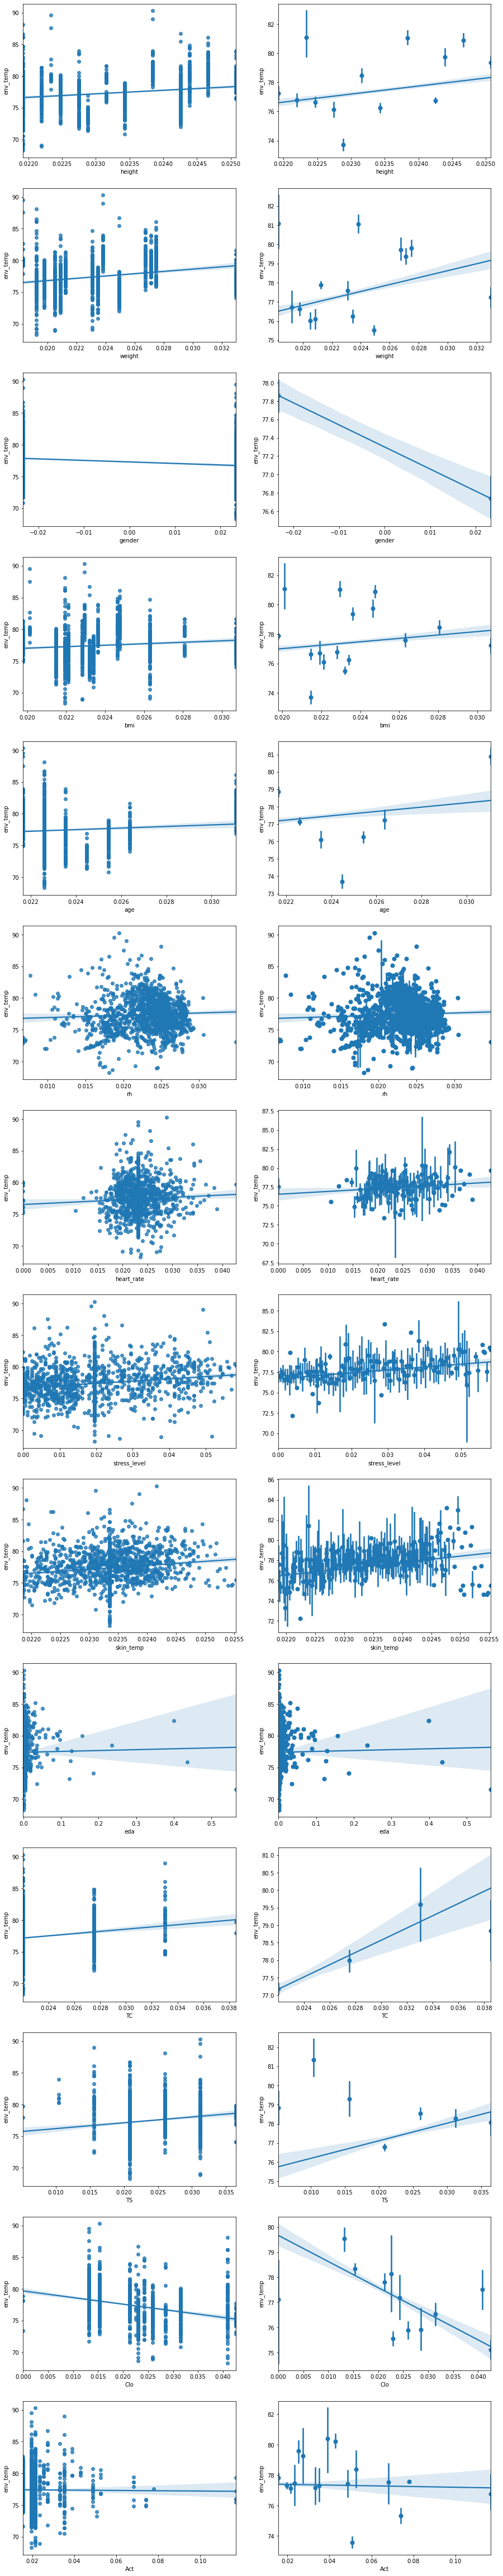

In [33]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression
env_temp = f(all features together)

In [34]:
regr = sm.OLS(y_train, X_train)

In [35]:
regr_fit = regr.fit()

In [36]:
y_pred = regr_fit.predict(X_test)

In [37]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
1465,74.597,74.885442
1466,79.853,75.118914
1467,79.151,75.768066
1468,74.964,75.485147
1469,76.071,76.931562
...,...,...
1827,80.029,77.646729
1828,74.727,78.068265
1829,76.876,77.304853
1830,67.671,76.080270


In [38]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          9.850e+04
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:25   Log-Likelihood:                         -3427.3
No. Observations:                1465   AIC:                                      6883.
Df Residuals:                    1451   BIC:                                      6957.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2543.8849    119.962     21.206      0.000    2308.567    2779.203
weight       -1112.8984     92.423    -12.041      0.000   -1294.195    -931.602
gender          10.8778      6.624      1.642      0.101      -2.117      23.872
bmi           1228.3857     88.536     13.874      0.000    1054.713    1402.058
age             36.9052     38.551      0.957      0.339     -38.716     112.526
rh               8.9920     18.390      0.489      0.625     -27.082      45.067
heart_rate      12.9248     19.547      0.661      0.509     -25.419      51.269
stress_level    25.3854      5.800      4.377      0.000      14.007      36.763
skin_temp      428.6258    108.719      3.943      0.000     215.363     641.888
eda             -2.3999      2.673     -0.898      0.369      -7.643       2.843
TC             139.6040     25.579      5.458      0.000      89.429     189.779
TS              89.2944     15.240      5.859      0.000      59.399     119.190
Clo            -81.2312      9.533     -8.521      0.000     -99.931     -62.531
Act             -5.6121      7.569     -0.742      0.459     -20.459       9.234
==============================================================================
Omnibus:                      186.056   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.895
Skew:                           0.660   Prob(JB):                    4.28e-117
Kurtosis:                       5.653   Cond. No.                         216.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# mean squared error
mean_squared_error(y_test, y_pred)

7.224251208202385

In [40]:
# R2 score
r2_score(y_test, y_pred)

0.1613195742066469

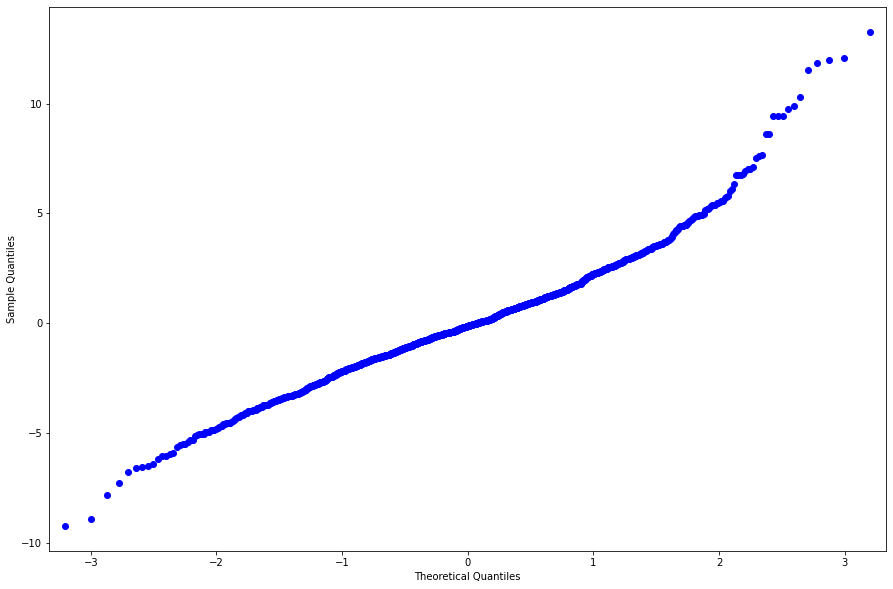

In [41]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.qqplot(regr_fit.resid)
plt.show()

## refine data

In [42]:
regr = sm.OLS(y_data, X_data)
regr_fit = regr.fit()

### leverage & outlier

In [43]:
infl = regr_fit.get_influence()

In [44]:
# leverage
leviers = infl.hat_matrix_diag
# list(leviers)

In [45]:
# studentized residue
res_studs = infl.resid_studentized_external
# list(res_studs)

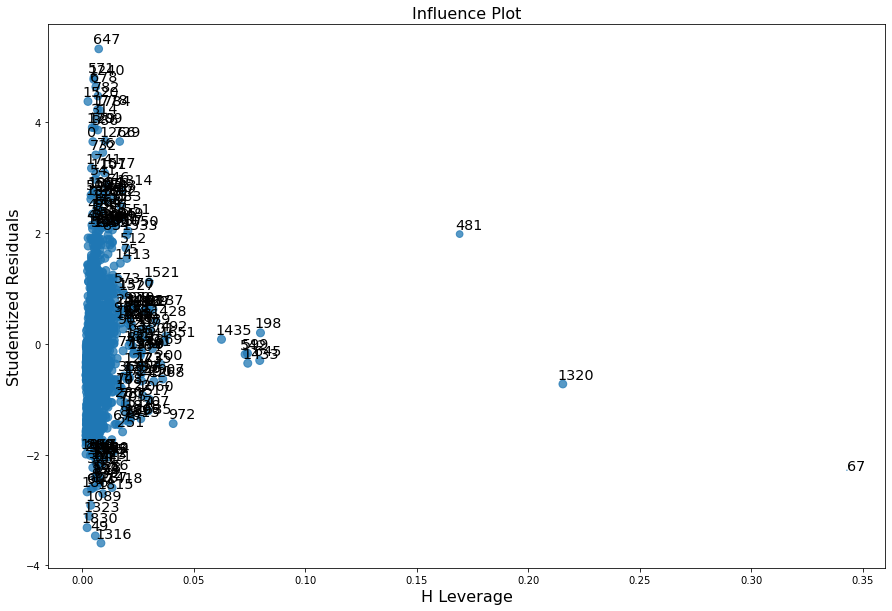

In [46]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.graphics.influence_plot(regr_fit, size=0.5)
plt.show()

### leverage detection
the threshold value may be:
$$s_h=2\times \frac{p+1}{n}$$

In [47]:
n_data = X_data.shape[0]
p_data = X_data.shape[1]

In [48]:
s_h = 2 * (p_data + 1) / n_data
s_h

0.016375545851528384

In [49]:
atyp_levier = leviers > s_h

In [50]:
X_data.index[atyp_levier]

Int64Index([  16,   58,   63,   67,   75,   96,  123,  127,  146,  164,  198,
             200,  207,  234,  251,  286,  338,  339,  360,  404,  481,  485,
             492,  512,  517,  542,  573,  583,  589,  599,  645,  651,  670,
             705,  707,  729,  743,  775,  778,  787,  823,  889,  899,  904,
             907,  911,  922,  928,  944,  967,  970,  972, 1006, 1019, 1050,
            1060, 1087, 1106, 1122, 1137, 1172, 1250, 1251, 1268, 1293, 1314,
            1320, 1324, 1336, 1350, 1369, 1370, 1413, 1428, 1433, 1435, 1490,
            1514, 1516, 1521, 1527, 1533, 1535, 1551, 1600, 1651, 1722, 1735,
            1761, 1801, 1813, 1828],
           dtype='int64')

In [51]:
leviers[atyp_levier]

array([0.02742619, 0.02123967, 0.02290714, 0.34291732, 0.01995036,
       0.02612739, 0.0262143 , 0.02113498, 0.02169569, 0.0259886 ,
       0.07986744, 0.03510999, 0.02518417, 0.01759473, 0.01802859,
       0.0171728 , 0.02074242, 0.02141278, 0.01854351, 0.02629635,
       0.16919838, 0.02188671, 0.03760233, 0.01950734, 0.02993911,
       0.07297292, 0.0165981 , 0.01715273, 0.0302687 , 0.07403142,
       0.07954296, 0.02054008, 0.01644761, 0.01923478, 0.02952951,
       0.01673484, 0.01744182, 0.01823547, 0.0206856 , 0.01926859,
       0.02252157, 0.02893346, 0.01956904, 0.0181756 , 0.03602357,
       0.0164344 , 0.02748696, 0.02062366, 0.02631963, 0.02996654,
       0.0226776 , 0.04071569, 0.0206444 , 0.01730106, 0.02040847,
       0.02712061, 0.01715768, 0.02156948, 0.01711869, 0.03162844,
       0.02134898, 0.02303699, 0.02281132, 0.03200913, 0.02060676,
       0.01760828, 0.21549757, 0.02162895, 0.02118301, 0.02293535,
       0.03134128, 0.01834638, 0.01700779, 0.03298191, 0.07415

In [52]:
len(leviers[atyp_levier])

92

### outlier detection
Threshold:
$$s_t=t_{1-0.05/2}(n-p-2)$$

In [53]:
seuil_stud = scipy.stats.t.ppf(0.975, df=n_data-p_data-2)
seuil_stud

1.9612711575823958

In [54]:
atyp_stud = np.abs(res_studs) > seuil_stud
atyp_stud

array([ True, False, False, ..., False,  True, False])

In [55]:
X_data.index[atyp_stud]

Int64Index([   0,   49,   67,   76,   85,  129,  137,  174,  186,  206,  246,
             289,  290,  300,  314,  347,  356,  370,  386,  391,  419,  473,
             474,  481,  506,  513,  524,  530,  541,  543,  564,  571,  583,
             607,  647,  672,  678,  729,  732,  742,  782,  830,  864,  868,
             880,  893,  900,  917,  923,  941, 1004, 1018, 1024, 1050, 1057,
            1089, 1101, 1123, 1144, 1150, 1187, 1195, 1240, 1266, 1286, 1307,
            1314, 1316, 1323, 1346, 1395, 1402, 1411, 1418, 1446, 1520, 1522,
            1530, 1533, 1543, 1547, 1551, 1577, 1586, 1595, 1649, 1692, 1709,
            1712, 1737, 1741, 1755, 1778, 1784, 1815, 1830],
           dtype='int64')

In [56]:
res_studs[atyp_stud]

array([ 3.65458049, -3.46582835, -2.28056277,  3.4575227 ,  1.96773839,
        3.90642789, -2.41367728, -2.42255558, -2.67044896,  2.0925273 ,
        2.8482801 , -1.9822472 , -2.0120262 , -2.23220233,  4.07330634,
        2.63058392, -2.06105197, -1.97417689,  3.8644772 , -2.22777711,
        2.1464037 , -2.04521913,  2.34660232,  1.98439084,  2.68792623,
        2.02621762,  2.12765602,  2.1604712 ,  2.97186223, -2.03696156,
        2.398187  ,  4.81198273,  2.49694721, -2.6001092 ,  5.32825519,
       -2.50561959,  4.64367212,  3.65634198,  3.41363184, -2.12457367,
        4.47747377,  2.59364466,  2.12884785,  2.43161664, -1.98621631,
       -2.43244432,  2.18108509, -2.61245887, -2.3914912 ,  2.13974678,
        2.07774642,  2.72870663,  2.74622106,  2.04124197, -1.98819938,
       -2.91359592,  3.08156239, -2.15687451, -2.05263832, -2.04288008,
       -2.56920947, -2.07684642,  4.77632504,  3.66445515,  2.04173092,
        2.61546359,  2.78653671, -3.59544366, -3.11028245,  2.19

In [57]:
len(res_studs[atyp_stud])

96

In [58]:
idx_eliminate_lvg_outl = np.logical_not(np.logical_or(atyp_levier, atyp_stud))

In [59]:
X_data.index[idx_eliminate_lvg_outl]

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1829, 1831],
           dtype='int64', length=1652)

## linear regression (2nd try)

In [60]:
X_data_refine = X_data[idx_eliminate_lvg_outl]
y_data_refine = y_data[idx_eliminate_lvg_outl]

In [61]:
n_rows = y_data_refine.shape[0]

train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

X_train = X_data_refine[:n_rows_train]
y_train = y_data_refine[:n_rows_train]

X_test = X_data_refine[n_rows_train:]
y_test = y_data_refine[n_rows_train:]

In [62]:
regr = sm.OLS(y_train, X_train)

In [63]:
regr_fit = regr.fit()

In [64]:
y_pred = regr_fit.predict(X_test)

In [65]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
1466,79.853,74.779874
1467,79.151,75.597536
1468,74.964,75.034398
1469,76.071,76.535458
1470,78.449,79.617854
...,...,...
1825,77.945,77.611296
1826,77.292,77.153098
1827,80.029,77.673456
1829,76.876,76.976146


In [66]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.438e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:31   Log-Likelihood:                         -2769.5
No. Observations:                1321   AIC:                                      5567.
Df Residuals:                    1307   BIC:                                      5640.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2571.1323    103.049     24.951      0.000    2368.973    2773.292
weight       -1224.7228     79.772    -15.353      0.000   -1381.219   -1068.227
gender           9.8412      5.492      1.792      0.073      -0.933      20.615
bmi           1324.1497     75.811     17.466      0.000    1175.425    1472.874
age             19.3258     32.903      0.587      0.557     -45.223      83.875
rh              20.9905     15.478      1.356      0.175      -9.374      51.355
heart_rate      -9.3407     21.318     -0.438      0.661     -51.162      32.481
stress_level    24.8790      5.046      4.930      0.000      14.979      34.779
skin_temp      457.1837     91.561      4.993      0.000     277.561     636.806
eda             16.2160      7.952      2.039      0.042       0.616      31.816
TC             105.8156     26.264      4.029      0.000      54.291     157.341
TS             123.0992     13.521      9.104      0.000      96.573     149.625
Clo            -99.4818      8.271    -12.027      0.000    -115.709     -83.255
Act             -7.1680     11.002     -0.652      0.515     -28.752      14.416
==============================================================================
Omnibus:                        3.495   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.444
Skew:                           0.095   Prob(JB):                        0.179
Kurtosis:                       2.838   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# mean squared error
mean_squared_error(y_test, y_pred)

4.136848932021232

In [68]:
# R2 score
r2_score(y_test, y_pred)

0.20310056287391387

notice that:
- MSE clearly drops.
- R2 increases a little.
- In p-value table, featrues gender, rh, eda drops a lot; features age, heart rate increases a little.

## feature selection

### correlation map for refine data

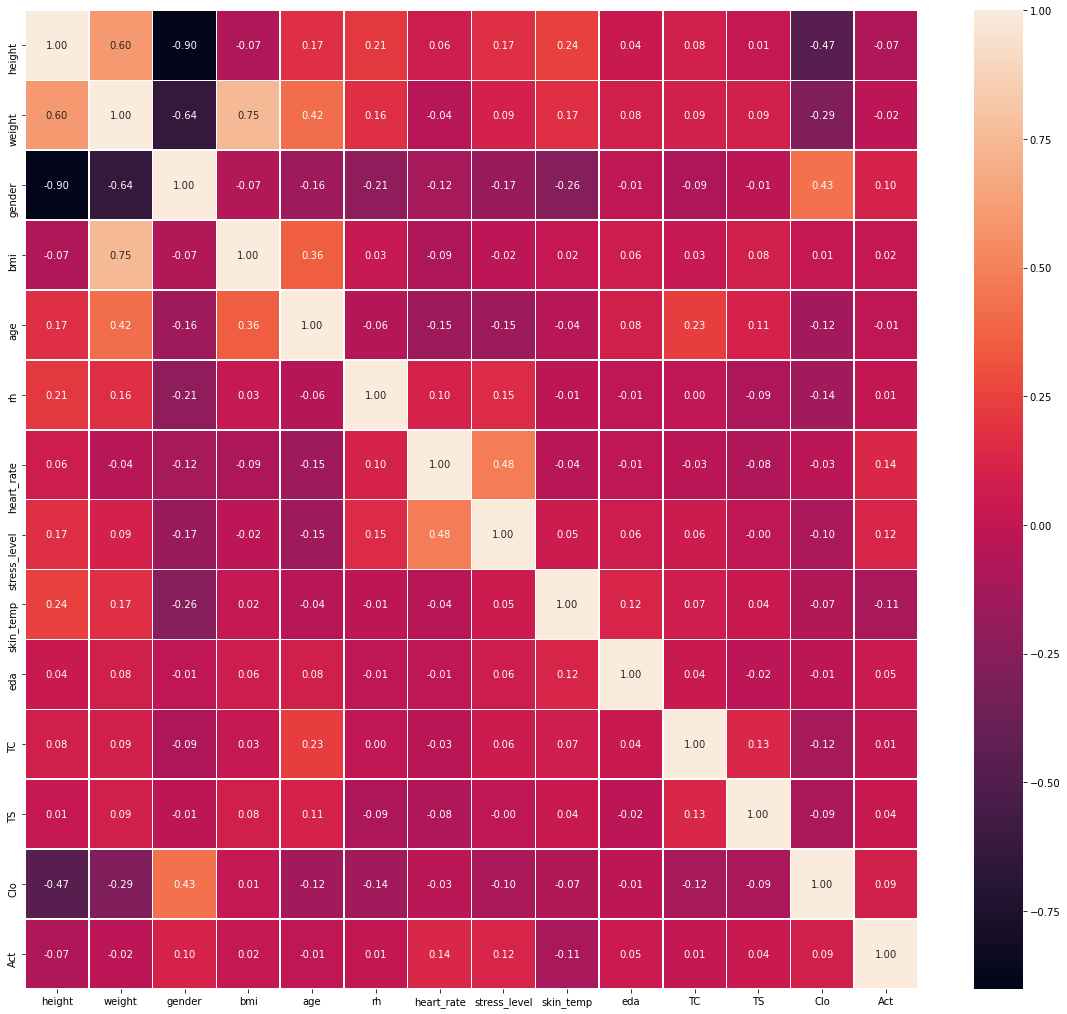

In [69]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_data_refine.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### backward selection

In [70]:
regr = sm.OLS(y_data_refine, X_data_refine)
regr_fit = regr.fit()

In [71]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.780e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:32   Log-Likelihood:                         -3473.1
No. Observations:                1652   AIC:                                      6974.
Df Residuals:                    1638   BIC:                                      7050.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2553.0420     93.890     27.192      0.000    2368.885    2737.199
weight       -1221.6042     71.813    -17.011      0.000   -1362.459   -1080.749
gender           8.4249      4.935      1.707      0.088      -1.255      18.105
bmi           1332.7798     68.022     19.593      0.000    1199.360    1466.199
age             -5.9115     29.971     -0.197      0.844     -64.698      52.875
rh              15.0802     13.770      1.095      0.274     -11.928      42.088
heart_rate     -13.2413     19.321     -0.685      0.493     -51.137      24.654
stress_level    22.0494      4.566      4.829      0.000      13.094      31.005
skin_temp      489.4278     82.988      5.898      0.000     326.654     652.202
eda             16.8239      6.676      2.520      0.012       3.729      29.919
TC             115.8615     23.403      4.951      0.000      69.958     161.765
TS             119.8002     12.263      9.769      0.000      95.747     143.853
Clo            -95.0585      7.301    -13.019      0.000    -109.379     -80.737
Act             -7.6439     10.356     -0.738      0.461     -27.957      12.669
==============================================================================
Omnibus:                        6.049   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.470
Skew:                           0.088   Prob(JB):                       0.0649
Kurtosis:                       2.780   Cond. No.                         225.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove age

In [72]:
X_rm = X_data_refine.drop(columns='age')

In [73]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.918e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:32   Log-Likelihood:                         -3473.1
No. Observations:                1652   AIC:                                      6972.
Df Residuals:                    1639   BIC:                                      7043.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2548.3821     90.842     28.053      0.000    2370.203    2726.562
weight       -1222.4138     71.675    -17.055      0.000   -1362.997   -1081.831
gender           8.2654      4.867      1.698      0.090      -1.281      17.812
bmi           1331.6327     67.753     19.654      0.000    1198.741    1464.525
rh              15.3446     13.700      1.120      0.263     -11.527      42.216
heart_rate     -13.2328     19.315     -0.685      0.493     -51.117      24.652
stress_level    22.2066      4.494      4.941      0.000      13.391      31.022
skin_temp      490.9300     82.614      5.942      0.000     328.890     652.970
eda             16.7478      6.663      2.514      0.012       3.679      29.817
TC             114.7347     22.689      5.057      0.000      70.233     159.237
TS             119.6947     12.248      9.773      0.000      95.671     143.718
Clo            -95.0368      7.298    -13.022      0.000    -109.352     -80.722
Act             -7.6505     10.353     -0.739      0.460     -27.958      12.657
==============================================================================
Omnibus:                        5.952   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                5.370
Skew:                           0.086   Prob(JB):                       0.0682
Kurtosis:                       2.780   Cond. No.                         213.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove heart rate

In [74]:
X_rm = X_rm.drop(columns='heart_rate')

In [75]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.078e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:32   Log-Likelihood:                         -3473.3
No. Observations:                1652   AIC:                                      6971.
Df Residuals:                    1640   BIC:                                      7036.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2530.3409     86.928     29.108      0.000    2359.839    2700.842
weight       -1206.0826     67.584    -17.846      0.000   -1338.642   -1073.523
gender           8.9527      4.762      1.880      0.060      -0.387      18.293
bmi           1317.2769     64.421     20.448      0.000    1190.920    1443.633
rh              15.0404     13.691      1.099      0.272     -11.813      41.894
stress_level    20.7542      3.962      5.238      0.000      12.982      28.526
skin_temp      495.3052     82.353      6.014      0.000     333.777     656.834
eda             16.7514      6.662      2.514      0.012       3.684      29.818
TC             115.2984     22.670      5.086      0.000      70.833     159.764
TS             120.1392     12.229      9.824      0.000      96.154     144.125
Clo            -95.0714      7.297    -13.029      0.000    -109.384     -80.759
Act             -8.4645     10.283     -0.823      0.411     -28.634      11.705
==============================================================================
Omnibus:                        6.187   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.565
Skew:                           0.088   Prob(JB):                       0.0619
Kurtosis:                       2.777   Cond. No.                         195.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove Act

In [76]:
X_rm = X_rm.drop(columns='Act')

In [77]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.268e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:32   Log-Likelihood:                         -3473.7
No. Observations:                1652   AIC:                                      6969.
Df Residuals:                    1641   BIC:                                      7029.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2519.1515     85.850     29.344      0.000    2350.764    2687.539
weight       -1204.5796     67.552    -17.832      0.000   -1337.077   -1072.082
gender           8.4994      4.729      1.797      0.072      -0.777      17.776
bmi           1314.8584     64.348     20.434      0.000    1188.646    1441.071
rh              14.8369     13.687      1.084      0.279     -12.009      41.683
stress_level    20.2966      3.923      5.174      0.000      12.602      27.991
skin_temp      501.6407     81.985      6.119      0.000     340.835     662.446
eda             16.5206      6.655      2.482      0.013       3.467      29.575
TC             115.0214     22.665      5.075      0.000      70.565     159.478
TS             119.6349     12.212      9.796      0.000      95.682     143.588
Clo            -95.5693      7.271    -13.144      0.000    -109.831     -81.308
==============================================================================
Omnibus:                        6.117   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.521
Skew:                           0.088   Prob(JB):                       0.0632
Kurtosis:                       2.779   Cond. No.                         185.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove rh

In [78]:
X_rm = X_rm.drop(columns='rh')

In [79]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.494e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:05:32   Log-Likelihood:                         -3474.3
No. Observations:                1652   AIC:                                      6969.
Df Residuals:                    1642   BIC:                                      7023.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2538.0346     84.069     30.190      0.000    2373.142    2702.928
weight       -1209.4962     67.403    -17.944      0.000   -1341.702   -1077.290
gender           8.4292      4.729      1.782      0.075      -0.847      17.705
bmi           1321.1634     64.088     20.615      0.000    1195.461    1446.866
stress_level    20.7936      3.896      5.337      0.000      13.152      28.435
skin_temp      497.3247     81.892      6.073      0.000     336.700     657.949
eda             16.3656      6.654      2.459      0.014       3.314      29.417
TC             114.9044     22.666      5.069      0.000      70.446     159.363
TS             118.4335     12.162      9.738      0.000      94.578     142.289
Clo            -95.9464      7.263    -13.210      0.000    -110.193     -81.700
==============================================================================
Omnibus:                        6.785   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                5.963
Skew:                           0.086   Prob(JB):                       0.0507
Kurtosis:                       2.761   Cond. No.                         173.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### correlation map for selected data

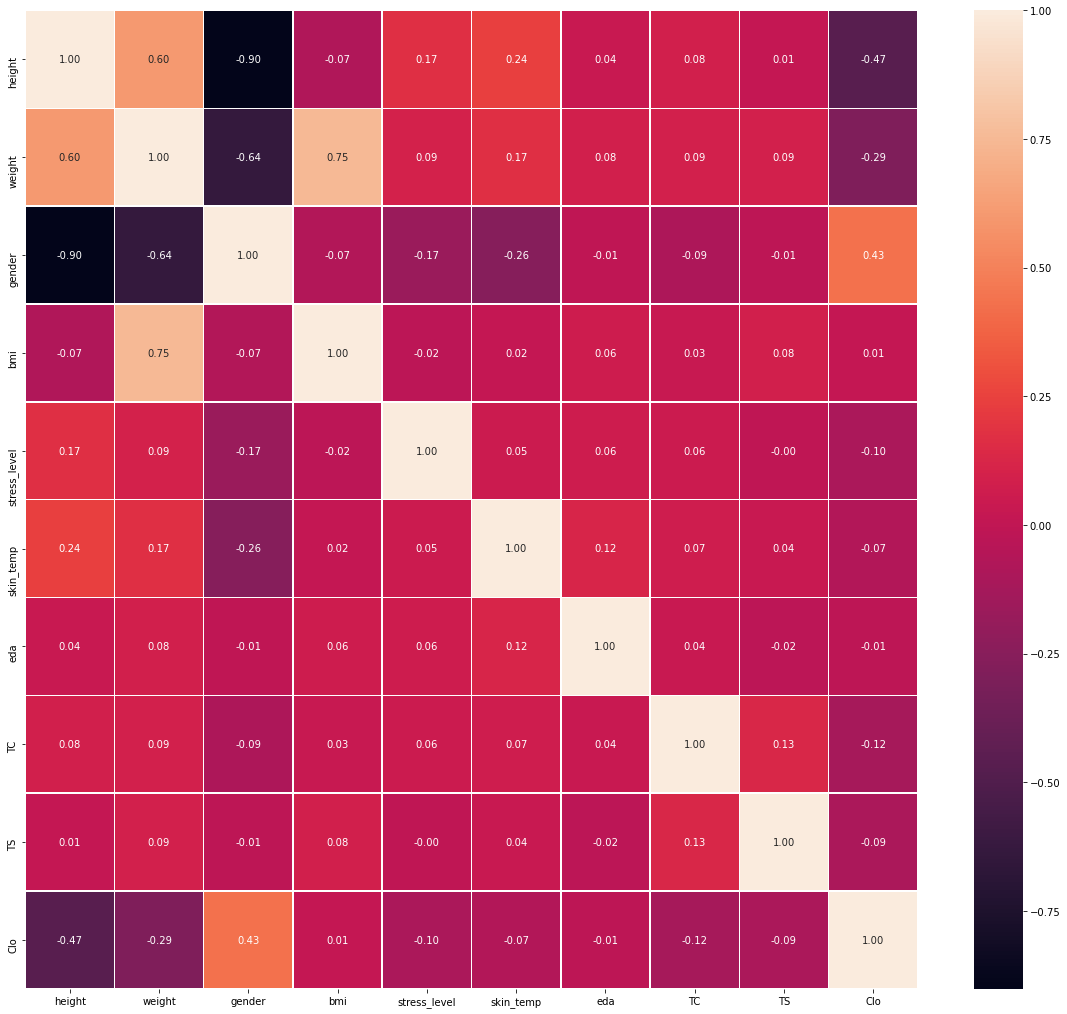

In [80]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_rm.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

## linear regression (3rd try)

### ?single linear regression

In [81]:
X_train, y_train, X_test, y_test = split_into_train_test(X_rm, y_data_refine)

In [82]:
n_features = X_train.shape[1]

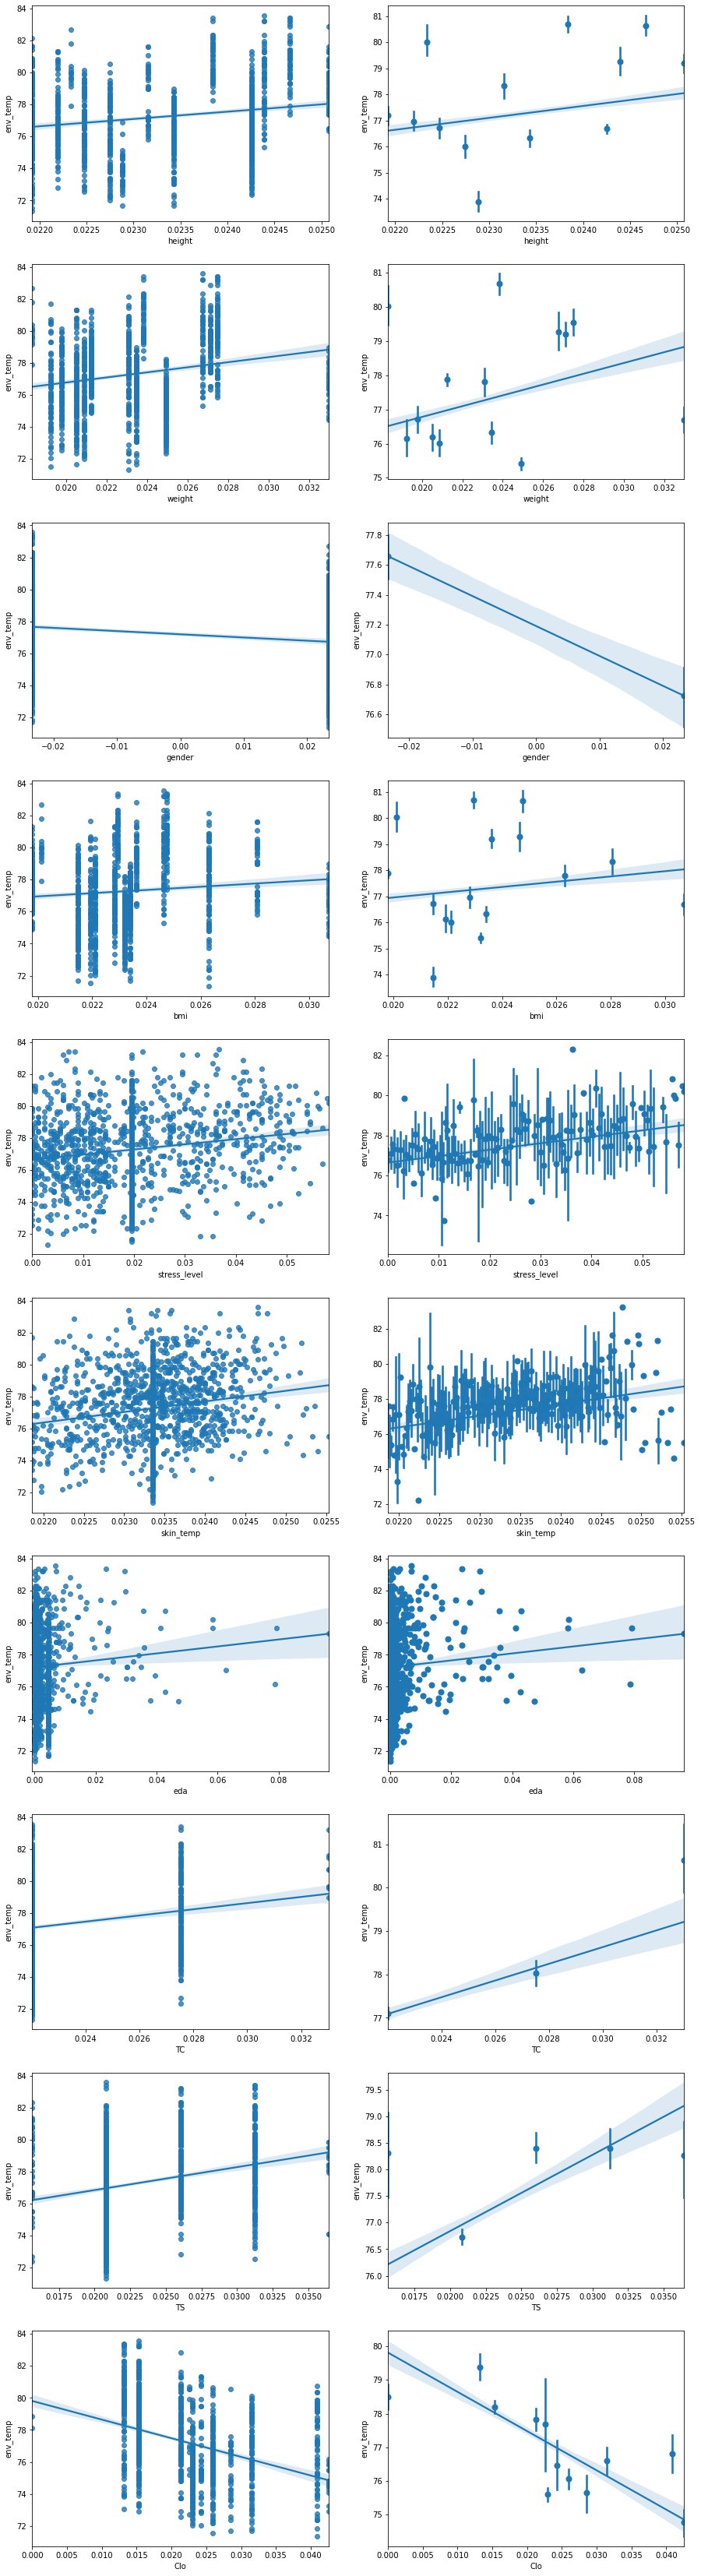

In [83]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression

In [84]:
regr = sm.OLS(y_train, X_train)

In [85]:
regr_fit = regr.fit()

In [86]:
y_pred = regr_fit.predict(X_test)

In [87]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
1466,79.853,74.922345
1467,79.151,75.465636
1468,74.964,74.942459
1469,76.071,76.547380
1470,78.449,79.694127
...,...,...
1825,77.945,77.597546
1826,77.292,77.138635
1827,80.029,77.661096
1829,76.876,77.162529


In [88]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.015e+05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:06:06   Log-Likelihood:                         -2770.8
No. Observations:                1321   AIC:                                      5562.
Df Residuals:                    1311   BIC:                                      5613.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        2585.4606     92.325     28.004      0.000    2404.339    2766.582
weight       -1213.4692     75.050    -16.169      0.000   -1360.701   -1066.238
gender          10.3425      5.275      1.961      0.050      -0.006      20.691
bmi           1321.9066     71.655     18.448      0.000    1181.336    1462.477
stress_level    23.6268      4.345      5.438      0.000      15.103      32.150
skin_temp      458.3132     90.327      5.074      0.000     281.111     635.515
eda             16.0545      7.924      2.026      0.043       0.510      31.599
TC             108.9031     25.417      4.285      0.000      59.040     158.766
TS             121.9343     13.415      9.090      0.000      95.618     148.251
Clo           -100.3789      8.232    -12.194      0.000    -116.528     -84.230
==============================================================================
Omnibus:                        4.208   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.065
Skew:                           0.101   Prob(JB):                        0.131
Kurtosis:                       2.818   Cond. No.                         171.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# mean squared error
mean_squared_error(y_test, y_pred)

4.122604193138453

In [90]:
# R2 score
r2_score(y_test, y_pred)

0.20584458968858155

## cross validation

In [91]:
from sklearn import metrics
# metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [92]:
lr = LinearRegression()
lr_cv_mse = cross_val_score(lr, X_rm, y_data_refine, scoring='neg_mean_squared_error', cv=10)

In [93]:
lr_cv_mse

array([-4.00439282, -3.66133305, -4.24871602, -3.55171943, -3.23990322,
       -4.32240767, -4.75267224, -3.81323931, -3.85377449, -4.23505502])

In [94]:
lr_cv_mse.mean()

-3.9683213283982837

In [95]:
lr_cv_r2 = cross_val_score(lr, X_rm, y_data_refine, scoring='r2', cv=10)

In [96]:
lr_cv_r2.mean()

0.24146605090506737